In [1]:
import optuna
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import ConcatDataset

from data_functions import *
from metric_functions import *
from helper_functions import *
from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform_blur = transforms.Compose(
    [transforms.GaussianBlur(3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_erase = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomErasing(0.5),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_color = transforms.Compose(
    [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_flip = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset_flip = load_data("./train", transform=transform_flip)
dataset_color = load_data("./train", transform=transform_color)
dataset_erase = load_data("./train", transform=transform_erase)
dataset_blur = load_data("./train", transform=transform_blur)
dataset = load_data("./train")
merged = ConcatDataset(
    [dataset_flip, dataset_color, dataset_erase, dataset_blur]
)
labels = dataset.classes

In [3]:
from models import *
from helper_functions import *

kernel_sizes_values = [[5, 3, 3], [7, 5, 5], [5, 3, 3, 1], [5, 3, 3, 1, 1]]
n_channels_values = [16, 32, 64]
hidden_sizes_values = [64, 128, 256]

In [4]:
def objective(trial):
    kernel_sizes = trial.suggest_categorical("kernel_sizes", kernel_sizes_values)
    n_channels = trial.suggest_categorical("n_channels", n_channels_values)
    hidden_size = trial.suggest_categorical("hidden_sizes", hidden_sizes_values)

    model = CustomNet(num_classes=len(labels), kernel_sizes=kernel_sizes, n_channels=n_channels, hidden_size=hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(merged, batch_size=32, shuffle=True)
    val, test = trai_val_split(dataset, 0.5)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

    train_model(model, train_loader, val_loader, criterion, optimizer, get_accuracy, device, num_epochs=10)
    return get_accuracy(model, test_loader, device)

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print(study.best_params)
print(study.best_value)

[I 2024-06-20 20:45:49,585] A new study created in memory with name: no-name-2b90a584-0f53-46c1-92f7-9612f7954875
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [5, 3, 3] which is of type list.
  warnings.warn(message)
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [7, 5, 5] which is of type list.
  warnings.warn(message)
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent

{'kernel_sizes': [5, 3, 3, 1], 'n_channels': 64, 'hidden_sizes': 256}
0.9988865154751625


/tmp/ipykernel_51344/2496925414.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


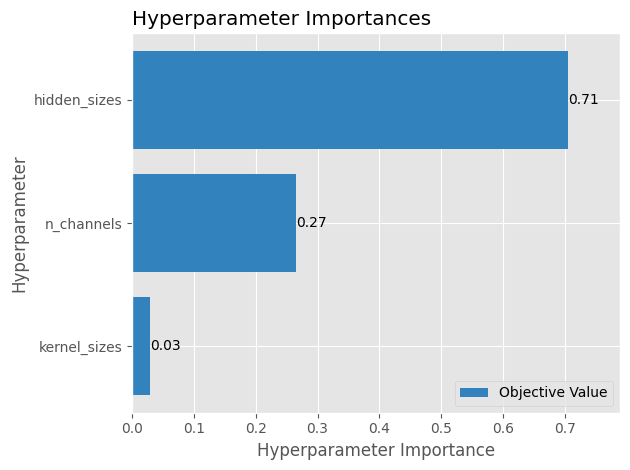

In [6]:
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.show()

/tmp/ipykernel_51344/2297176039.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study)
[W 2024-06-21 10:36:05,717] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


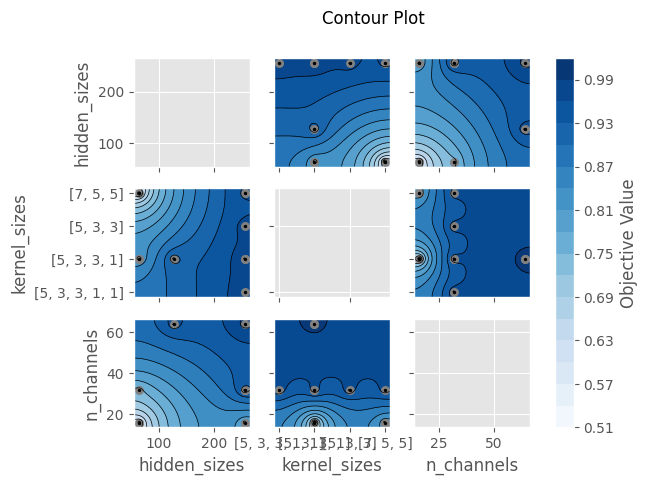

In [7]:
fig = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

## Finałowy model

In [8]:
dataset_flip = load_data("./train", transform=transform_flip)
dataset_color = load_data("./train", transform=transform_color)
dataset_erase = load_data("./train", transform=transform_erase)
dataset_blur = load_data("./train", transform=transform_blur)
dataset = load_data("./train")
merged = ConcatDataset(
    [dataset, dataset_flip, dataset_color, dataset_erase, dataset_blur]
)
labels = dataset.classes

In [9]:
model = CustomNet(num_classes=len(labels), kernel_sizes=[5, 3, 3, 1], n_channels=64, hidden_size=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(merged, batch_size=32, shuffle=True)
val, test = trai_val_split(dataset, 0.5)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
loss_hist, train_eval_hist, val_eval_hist = train_model(model, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 10)
torch.save(model.state_dict(), "final_model.pth")

100%|██████████| 10/10 [1:41:01<00:00, 606.19s/it]


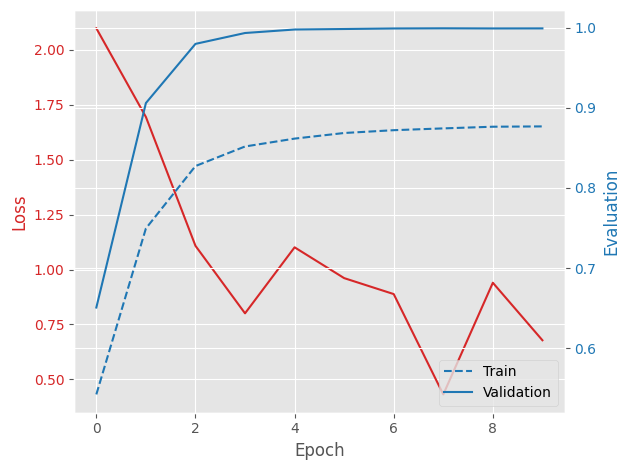

In [10]:
iters = np.arange(10)
plot_training(iters, loss_hist, train_eval_hist, val_eval_hist)

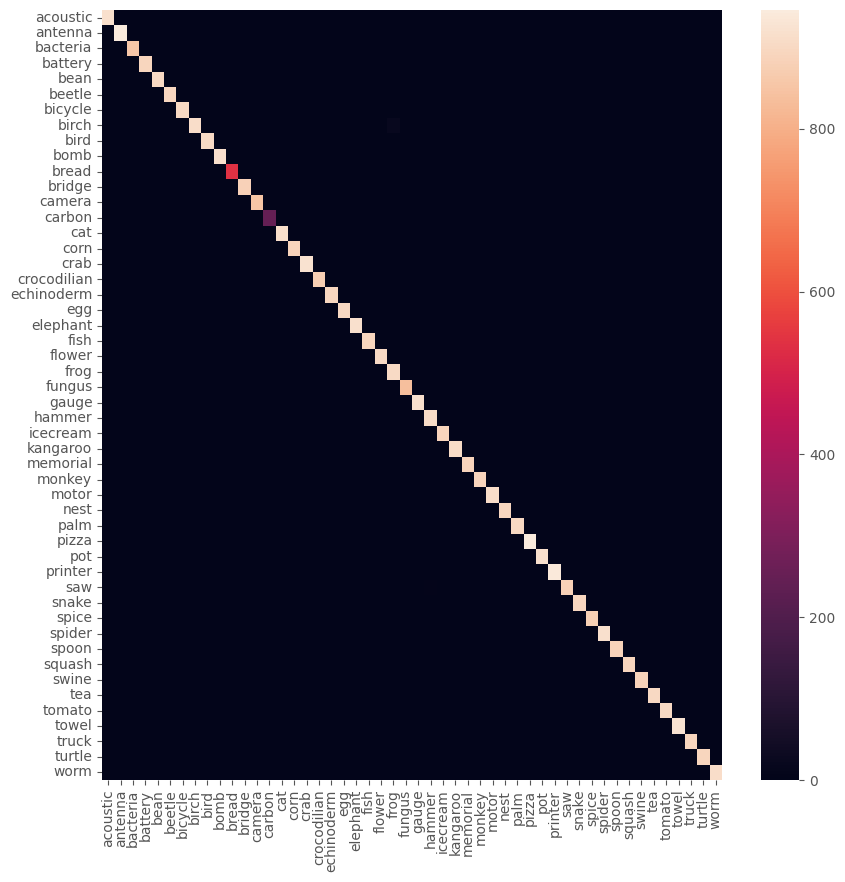

In [15]:
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
confusion_matrix = get_confusion_matrix(model, test_loader, classes=labels, device=device) 
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, ax=ax)
plt.show()

In [12]:
acc = get_accuracy(model, test_loader, device)
print(f"Final accuracy: {acc}")

Final accuracy: 0.9990683088669727


In [5]:
test_all = load_data("./test_all")
test_loader = torch.utils.data.DataLoader(test_all, batch_size=32, shuffle=False)

model = CustomNet(num_classes=50, kernel_sizes=[5, 3, 3, 1], n_channels=64, hidden_size=256).to(device)
model.load_state_dict(torch.load("final_model.pth"))
model.eval()
preds = []
for x in test_loader:
    x = x[0].to(device)
    with torch.no_grad():
        out = model(x)
    preds.append(out.argmax(dim=1).cpu().numpy())
preds = np.concatenate(preds)
preds_df = pd.DataFrame(preds)
filenames = [f[0].split("/")[-1].upper() for f in test_loader.dataset.imgs]
preds_df.insert(0, "Filename", filenames)
preds_df.to_csv("predictions.csv", header=False, index=False)